In [1]:
import os
import sys

parent_dir = os.path.dirname('/home/jupyter/')
sys.path.append(parent_dir)

import warnings
warnings.filterwarnings("ignore")

import torch
import numpy as np
import anndata
import scanpy as sc
import yaml
import tqdm

import itertools

import scipy
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import cudf
import cuml

In [3]:
from cellarium.ml.core import CellariumPipeline, CellariumModule
from cellarium.ml.utilities.data import AnnDataField, densify
from cellarium.ml.core.datamodule import CellariumAnnDataDataModule
from cellarium.ml.data import (
    DistributedAnnDataCollection,
    IterableDistributedAnnDataCollectionDataset,
)

import pandas as pd
import tempfile

def get_pretrained_model_as_pipeline(
    trained_model: str = "../", 
    transforms: list[torch.nn.Module] = [],
    device: str = "cuda",
) -> CellariumPipeline:

    model = CellariumModule.load_from_checkpoint(trained_model).model

    # insert the trained model params
    model.to(device)
    model.eval()

    # construct the pipeline
    pipeline = CellariumPipeline(transforms + [model])

    return pipeline

In [4]:
class AutosizedDistributedAnnDataCollection(DistributedAnnDataCollection):

    def __init__(self, *args, **kwargs):
        # I'm being lazy here and doing something real ugly
        # I want it to take the shard_size from the first file
        try:
            # this allows super to find the list of filenames
            super().__init__(*args, **kwargs)
        except AssertionError:
            try:
                # this allows super to create the cache
                kwargs.pop("shard_size")
                kwargs = kwargs | {"shard_size": 10000}
                super().__init__(*args, **kwargs)
            except AssertionError:
                pass
            # load first file and cache it
            adata0 = self.cache[self.filenames[0]] = read_h5ad_file(self.filenames[0])
            # pull shard_size from that file
            kwargs.pop("shard_size")
            kwargs = kwargs | {"shard_size": len(adata0)}
            # finally initialize for real
            super().__init__(*args, **kwargs)


def get_dataset_from_anndata(
    adata: anndata.AnnData | str, 
    batch_size: int = 2048, 
    shard_size: int | None = None, 
    shuffle: bool = False, 
    seed: int = 0, 
    drop_last: bool = False,
):
    """
    Get IterableDistributedAnnDataCollectionDataset from an AnnData object or h5ad file specifier.

    Args:
        adata: AnnData object or h5ad file, allowing brace notation for several files.
        batch_size: Batch size.
        shard_size: Shard size.
        shuffle: Whether to shuffle the dataset.
        seed: Random seed.
        drop_last: Whether to drop the last incomplete batch.

    Returns:
        IterableDistributedAnnDataCollectionDataset.
    """

    if isinstance(adata, anndata.AnnData):
        tmpfile = tempfile.mkstemp(suffix='.h5ad')
        adata.write(tmpfile[1])
        file = tmpfile[1]
    else:
        file = adata

    dadc = AutosizedDistributedAnnDataCollection(
        file,
        shard_size=shard_size,
        max_cache_size=1,
    )

    dataset = IterableDistributedAnnDataCollectionDataset(
        dadc,
        batch_keys={
            "x_ng": AnnDataField(attr="X", convert_fn=densify),
            "var_names_g": AnnDataField(attr="var_names"),
        },
        batch_size=batch_size,
        shuffle=shuffle,
        seed=seed,
        drop_last=drop_last,
    )
    return dataset

In [5]:
config_file = "../yaml/nmf_heart_config_notebook.yaml"
checkpoint_file = '../NMF.ckpt'

In [6]:
pipeline = get_pretrained_model_as_pipeline(
    trained_model=checkpoint_file,
)

In [7]:
# get the location of the dataset
with open(config_file, "r") as file:
    config_dict = yaml.safe_load(file)
data_path = config_dict['data']['dadc']['init_args']['filenames']
print(f'Data is coming from {data_path}')

# get a dataset object
dataset = get_dataset_from_anndata(
    data_path, 
    batch_size=2048, # 256, # 4096, # 
    shard_size=665234, # 147523, # 304652, # 
    shuffle=False, 
    seed=0, 
    drop_last=False,
)

Data is coming from /home/jupyter/data/human_heart_atlas_hvg_scvi_rec.h5ad


In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
pipeline.to(device)
pipeline.eval()

CellariumPipeline(
  (0): NonNegativeMatrixFactorization()
)

In [9]:
from cellarium.ml.models.nmf import consensus

k=10
silhouette score: 0.7344


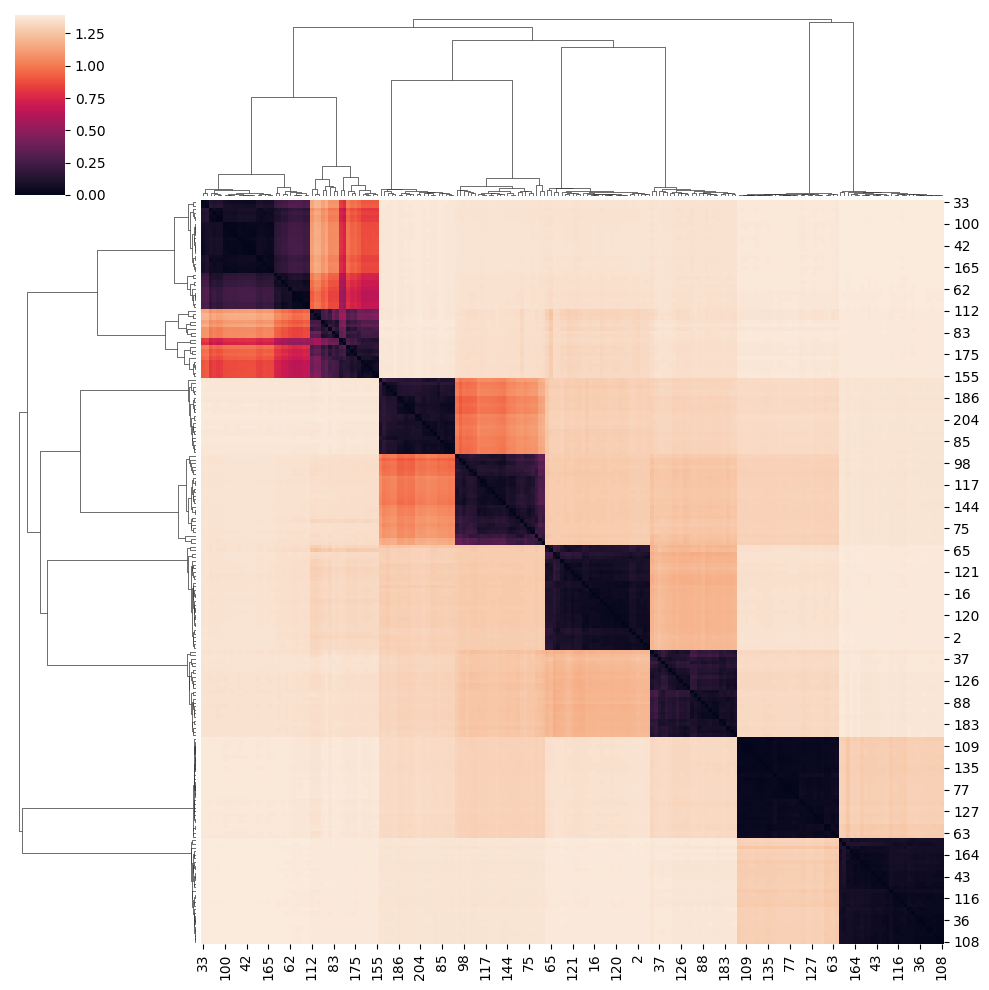

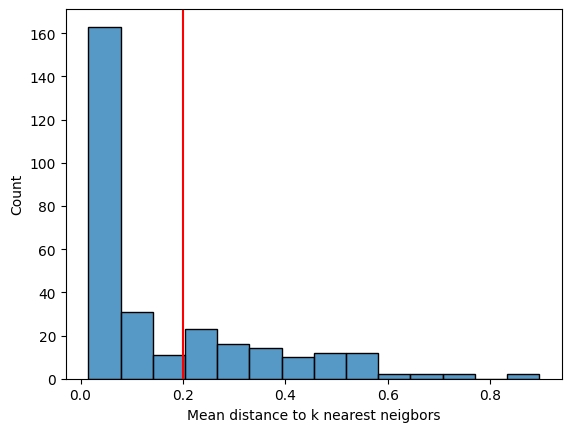

k=15
silhouette score: 0.7882


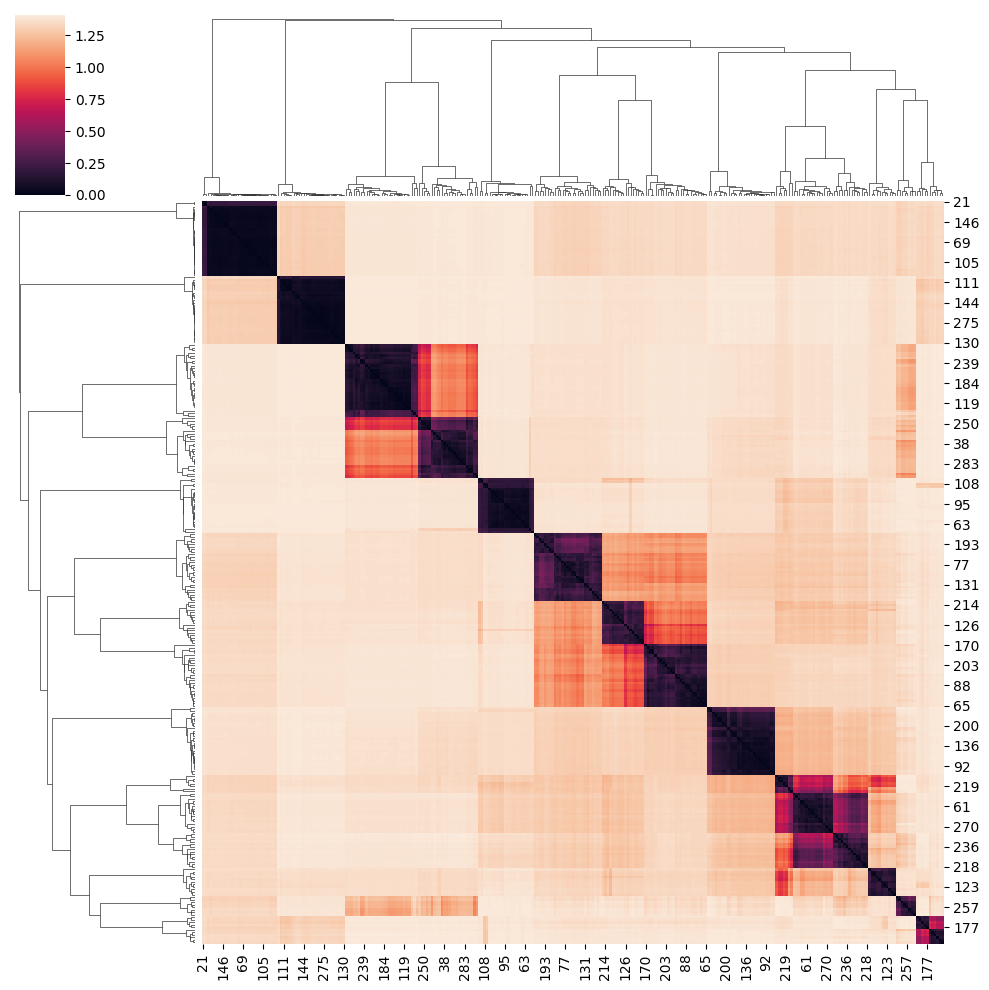

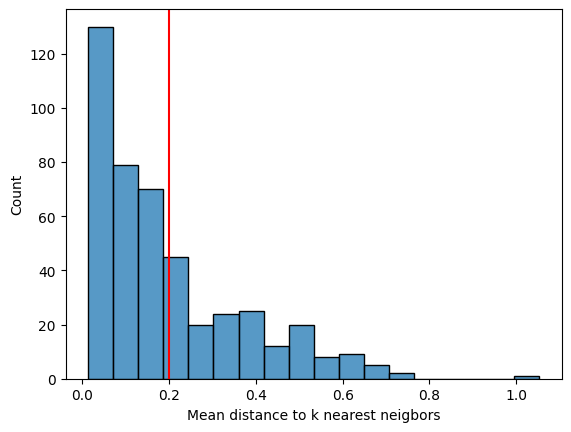

k=20
silhouette score: 0.8126


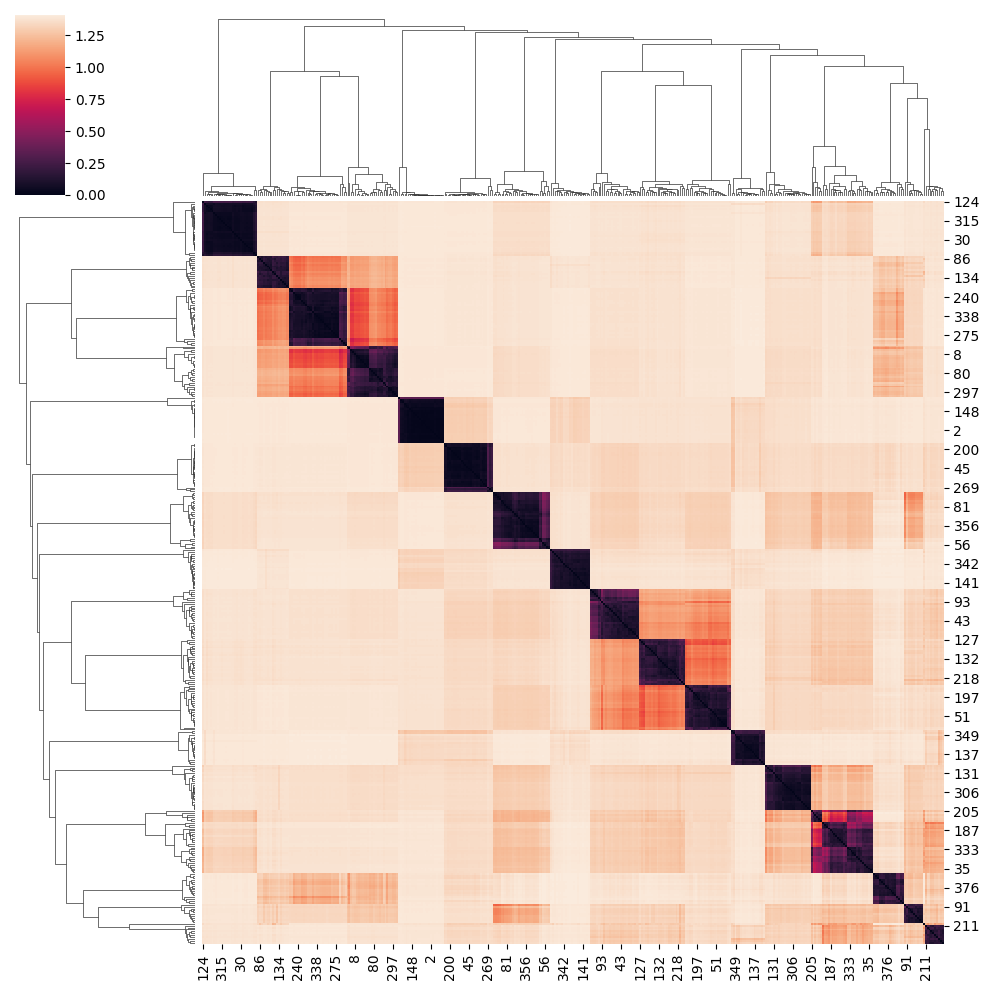

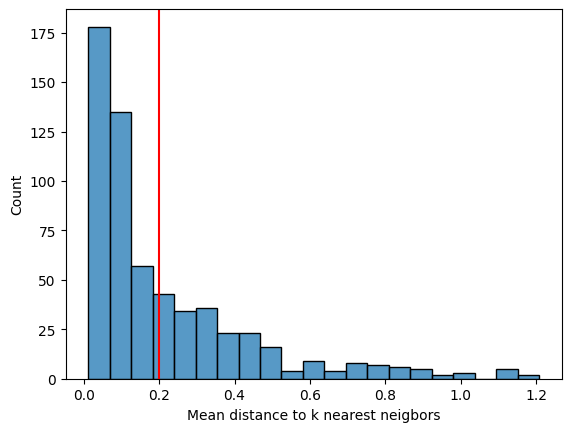

k=25
silhouette score: 0.7898


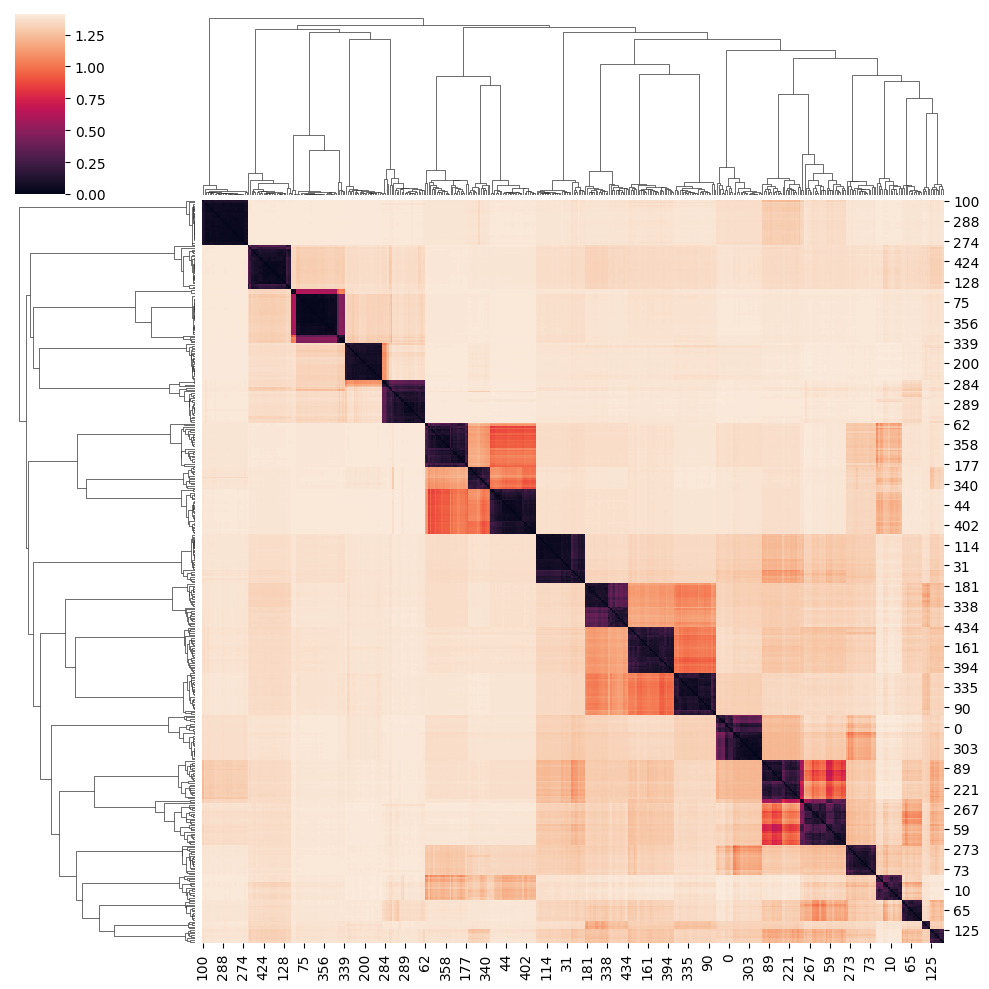

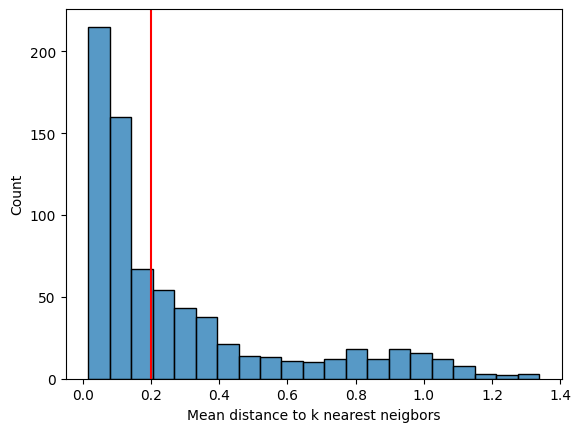

k=30
silhouette score: 0.6589


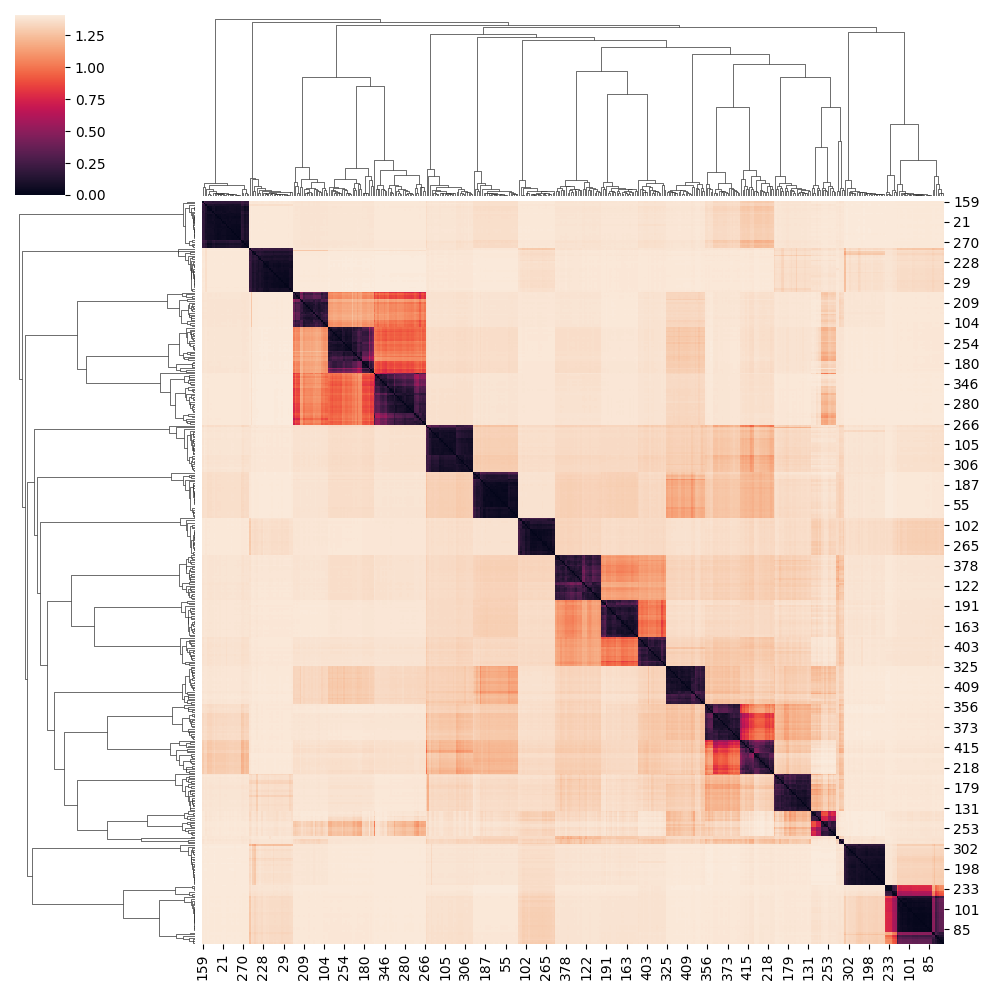

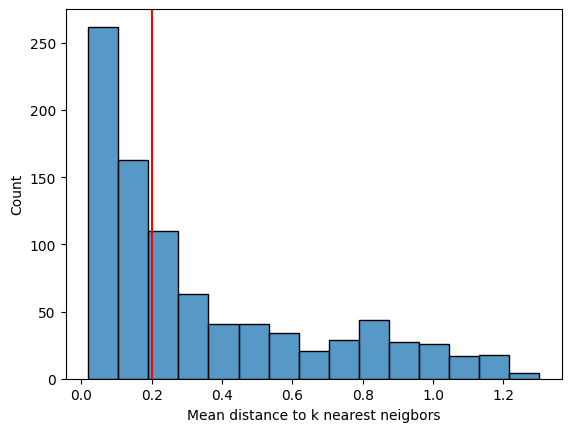

In [20]:
torch.manual_seed(0)
k_range = pipeline[-1].k_range
density_threshold = 0.2
local_neighborhood_size = 0.3
silhouette_scores = {}

for k in k_range:
    print('k='+str(k))
    D_rkg = getattr(pipeline[-1], f"D_{k}_rkg")
    consensus_output = consensus(D_rkg=D_rkg, k=k, 
                                 density_threshold=density_threshold,
                                 local_neighborhood_size=density_threshold)
    silhouette_scores[k] = consensus_output['stability']
    setattr(pipeline[-1], f"D_{k}_kg", consensus_output['consensus_D'])
    
    sns.clustermap(consensus_output['topk_euc_dist'].cpu().numpy())
    plt.show()
    sns.histplot(consensus_output['local_neigh_dist'].cpu().numpy())
    ymax = plt.gca().get_ylim()[1]
    plt.vlines(density_threshold, ymin=0, ymax=ymax, color='Red')
    plt.xlabel('Mean distance to k nearest neigbors')
    plt.ylim(0, ymax)
    plt.show()

In [21]:
from scipy import sparse
def calculate_rec_error(
    dataset: IterableDistributedAnnDataCollectionDataset,
    pipeline: CellariumPipeline, 
    obsm_key_added: str = 'X_nmf',
    maximum_anndata_files_to_download: int = 5,
) -> anndata.AnnData:
    """
    Embed the dataset using the pipeline.

    Args:
        dataset: Dataset.
        pipeline: Pipeline.
        maximum_anndata_files_to_download: Maximum number of anndata files to download.

    Returns:
        AnnData with scVI embeddings in adata.obsm[obsm_key_added]
    """
    
    # get the anndata object
    adatas = [dataset.dadc.adatas[i].adata for i in range(min(maximum_anndata_files_to_download, 
                                                              len(dataset.dadc.adatas)))]
    adata = anndata.concat(adatas, axis=0, merge="same")

    # get the latent space dimension
    # latent_space_dim = pipeline[-1].k
    
    rec_error = np.zeros((len(k_range),1)).astype('float64')
    for batch in tqdm.tqdm(dataset):
        
        batch['x_ng'] = torch.from_numpy(batch['x_ng']).to(device)
        out = pipeline.predict(batch)
        rec_error += out['rec_error']
    
    return rec_error 

In [15]:
errors = calculate_rec_error(dataset, pipeline)

100%|██████████| 325/325 [10:56<00:00,  2.02s/it]


In [26]:
# errors = np.log10(errors)
# errors = np.power(10, errors)

In [22]:
eval_metrics = pd.DataFrame.from_dict(silhouette_scores, orient='index')
eval_metrics.columns = ['stability']
# eval_metrics['rec_error'] = errors
eval_metrics

,stability
10,0.734419
15,0.788243
20,0.812581
25,0.789765
30,0.658890


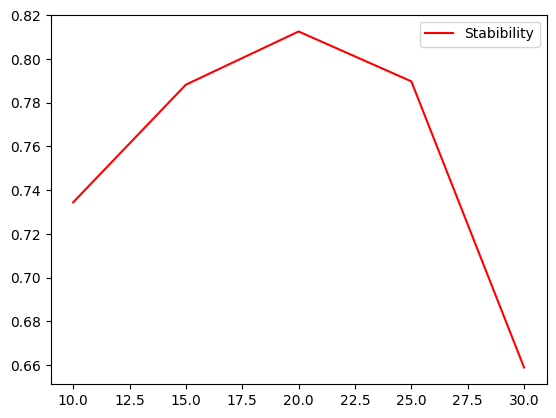

In [23]:
plt.plot(eval_metrics.index, eval_metrics['stability'], color='Red', label='Stabibility')
# plt.twinx()
# plt.plot(eval_metrics.index, eval_metrics['rec_error'], color='Blue', label='Reconstruction error')
plt.legend()

In [19]:
from scipy import sparse
def embed(
    dataset: IterableDistributedAnnDataCollectionDataset,
    pipeline: CellariumPipeline, 
    obsm_key_added: str = 'X_nmf',
    maximum_anndata_files_to_download: int = 5,
) -> anndata.AnnData:
    """
    Embed the dataset using the pipeline.

    Args:
        dataset: Dataset.
        pipeline: Pipeline.
        maximum_anndata_files_to_download: Maximum number of anndata files to download.

    Returns:
        AnnData with scVI embeddings in adata.obsm[obsm_key_added]
    """
    
    # get the anndata object
    adatas = [dataset.dadc.adatas[i].adata for i in range(min(maximum_anndata_files_to_download, 
                                                              len(dataset.dadc.adatas)))]
    adata = anndata.concat(adatas, axis=0, merge="same")

    # get the latent space dimension
    # latent_space_dim = pipeline[-1].k
    
    embedding = []
    for batch in tqdm.tqdm(dataset):
        
        batch['x_ng'] = torch.from_numpy(batch['x_ng']).to(device)
        out = pipeline.predict(batch)
        z = out['alpha_nk']
        embedding += [z.cpu()]
        
    adata.obsm[obsm_key_added] = np.asarray(torch.cat(embedding))
    
    return adata

In [20]:
adata = embed(dataset, pipeline)

100%|██████████| 325/325 [02:32<00:00,  2.14it/s]


In [21]:
reducer = cuml.UMAP(
    n_neighbors=15,
    n_components=2,
    n_epochs=500,
    min_dist=0.15,
    metric='cosine'
)
embedding = reducer.fit_transform(adata.obsm['X_nmf'])

In [22]:
adata.obsm['X_nmf_umap'] = embedding

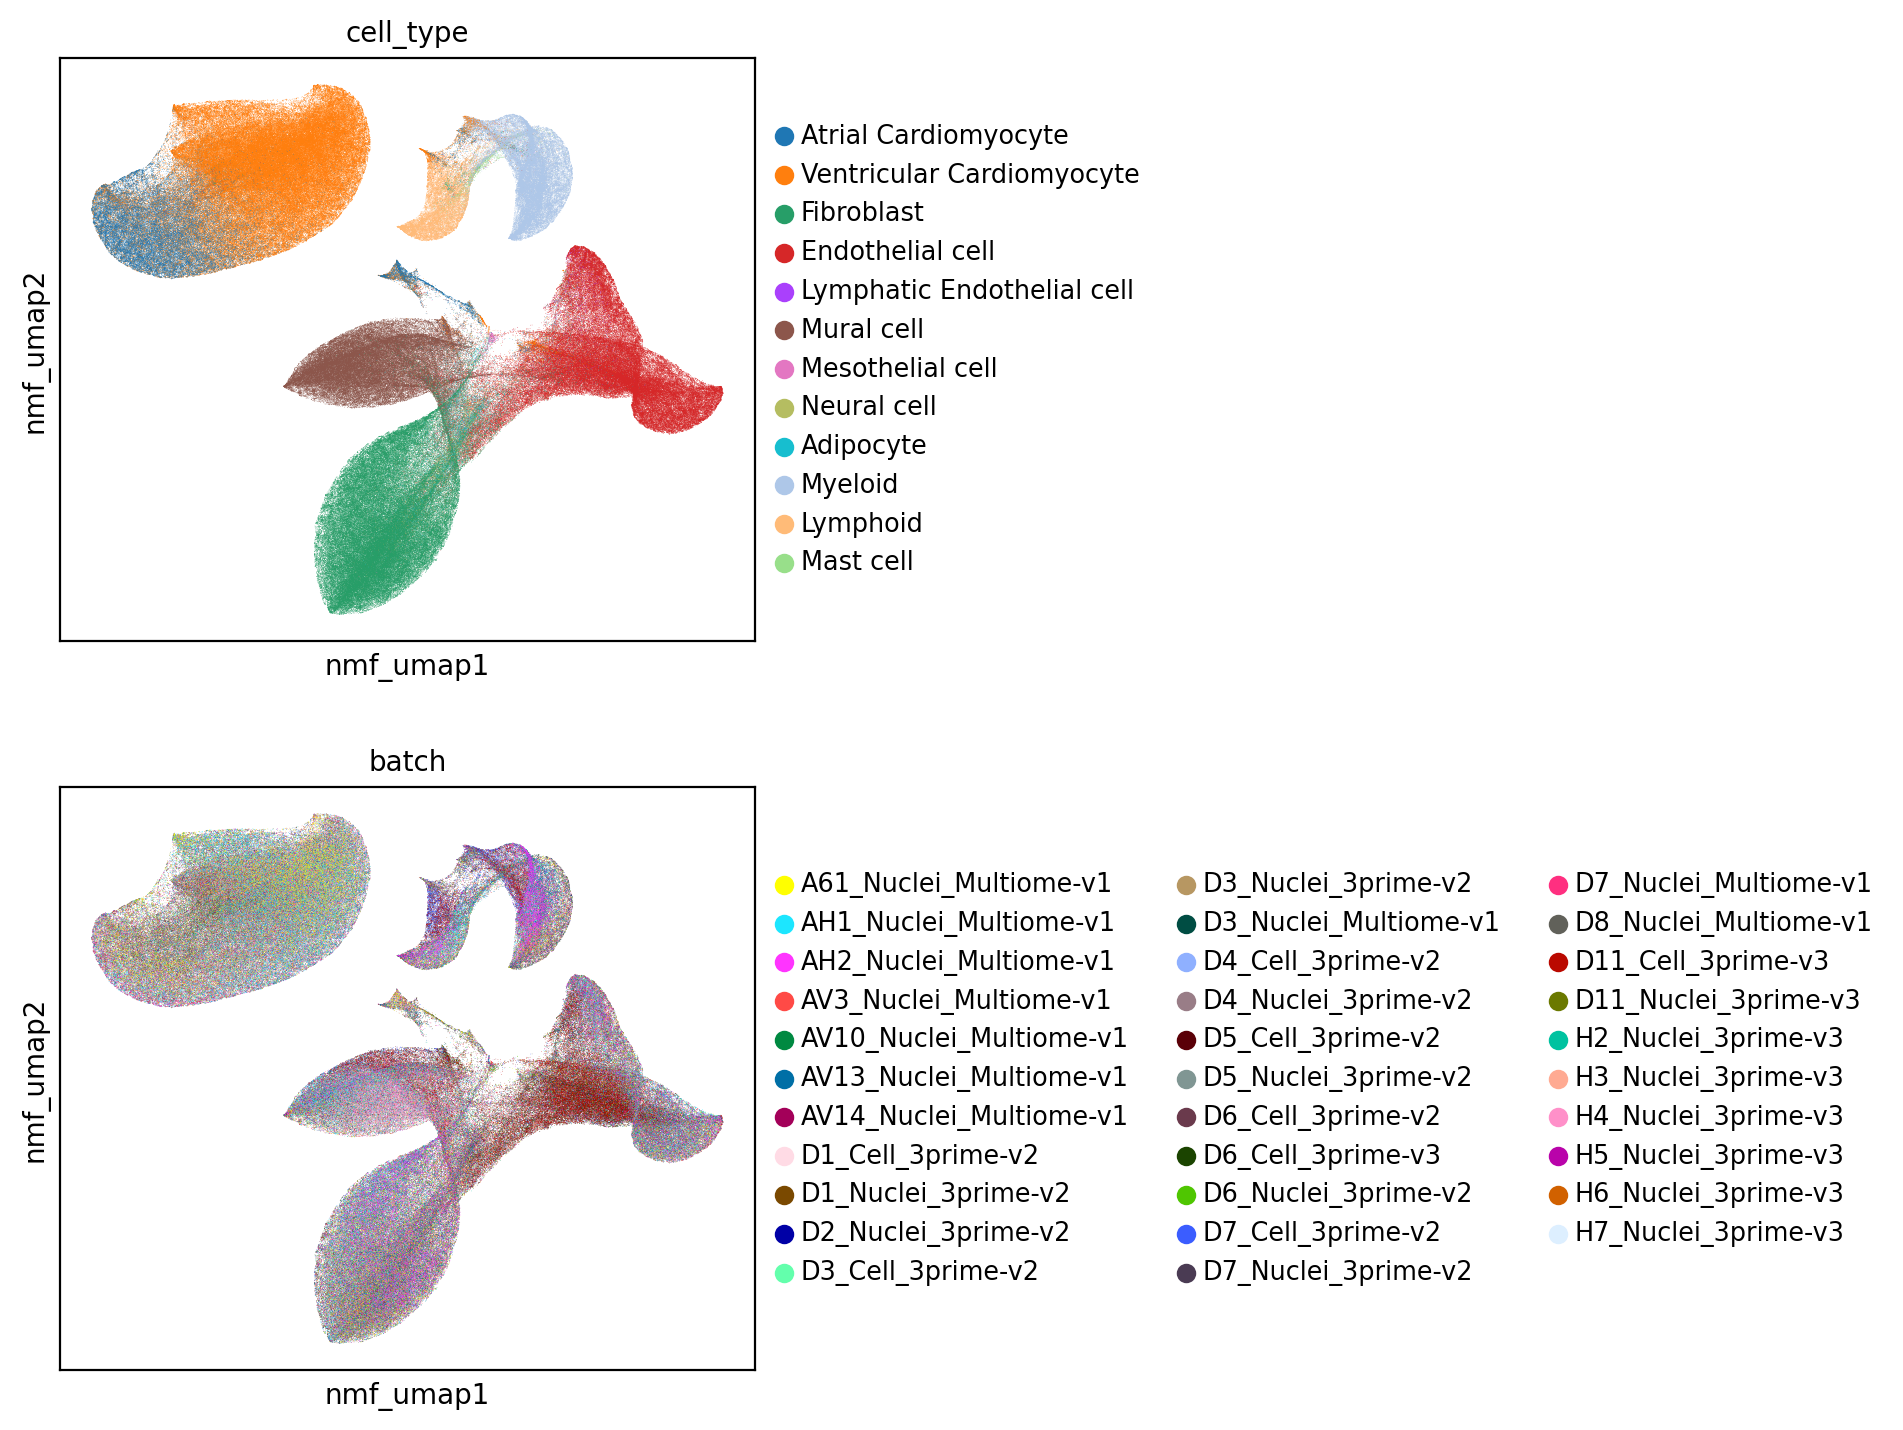

In [23]:
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=100, vector_friendly=True, fontsize=10)
sc.pl.embedding(adata, basis='nmf_umap', color=['cell_type', 'batch'], ncols=1,) # 'cell_state',
                # save='cellarium_nmf_liretina.pdf') # ,'cell_state'